<a href="https://colab.research.google.com/github/kalawinka/policorp/blob/main/examples/example_data_analysis_policorp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Analysis of the last Bundestag debate before the election, on 2025-02-11

In [ ]:
# Import libraries
import pandas as pd
import json

In [ ]:
# Open JSON file
with open('pollux-data-67.json', 'r') as openfile:
    # Read from json file
    json_object = json.load(openfile)

In [ ]:
# Convert json to dataframe
df = pd.json_normalize(json_object['data'])
# Show first 5 rows
df.head()

,_index,_id,_score,_ignored,_source.agenda_id,_source.sessionno,_source.date,_source.source_file,_source.description,_source.agenda_type,_source.agenda_nr,_source.speech_id,_source.name,_source.role,_source.party,_source.position,_source.speaker_id,_source.party_id,_source.text_raw
0,germaparl_v3,jgO5wpUBWpaIjqYnkDJd,1,[text_raw.text.keyword],1_20212_212,212,2025-02-11,https://dserver.bundestag.de/btp/20/20212.xml,Vereinbarte Debatte: (Schluss: 12.51 Uhr),None,1,1_20212_212_13,Christian Lindner,mp,FDP,None,11004097,10,"[{'seq_no': 0, 'legal_ner': None, 'ner': None,..."
1,germaparl_v3,igO5wpUBWpaIjqYnkDI4,1,[text_raw.text.keyword],1_20212_212,212,2025-02-11,https://dserver.bundestag.de/btp/20/20212.xml,Vereinbarte Debatte: (Schluss: 12.51 Uhr),None,1,1_20212_212_1,Olaf Scholz,government,not known,Bundeskanzler,11003231,24,"[{'seq_no': 0, 'legal_ner': None, 'ner': None,..."
2,germaparl_v3,lAO5wpUBWpaIjqYnkDKC,1,NaN,1_20212_212,212,2025-02-11,https://dserver.bundestag.de/btp/20/20212.xml,Vereinbarte Debatte: (Schluss: 12.51 Uhr),None,1,1_20212_212_19,Dr. Alice Weidel,mp,AfD,None,11004930,0,"[{'seq_no': 0, 'legal_ner': None, 'ner': None,..."
3,germaparl_v3,mQO5wpUBWpaIjqYnkTKK,1,[text_raw.text.keyword],1_20212_212,212,2025-02-11,https://dserver.bundestag.de/btp/20/20212.xml,Vereinbarte Debatte: (Schluss: 12.51 Uhr),None,1,1_20212_212_23,Alexander Dobrindt,mp,CDU/CSU,None,11003516,27,"[{'seq_no': 0, 'legal_ner': None, 'ner': None,..."
4,germaparl_v3,nwO5wpUBWpaIjqYnkTKx,1,NaN,1_20212_212,212,2025-02-11,https://dserver.bundestag.de/btp/20/20212.xml,Vereinbarte Debatte: (Schluss: 12.51 Uhr),None,1,1_20212_212_29,Tino Chrupalla,mp,AfD,None,11004695,0,"[{'seq_no': 0, 'legal_ner': None, 'ner': None,..."


In [ ]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

In [ ]:
# Helper function
# Wraps long text in y-axis
def wrap_y_labels(ax, width, rotation, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=rotation)

## Show all speakers without presidency role and number of speeches per speaker and party

In [ ]:
# Select speeches of non-president speakers
sel = df[df['_source.role'] != 'presidency']

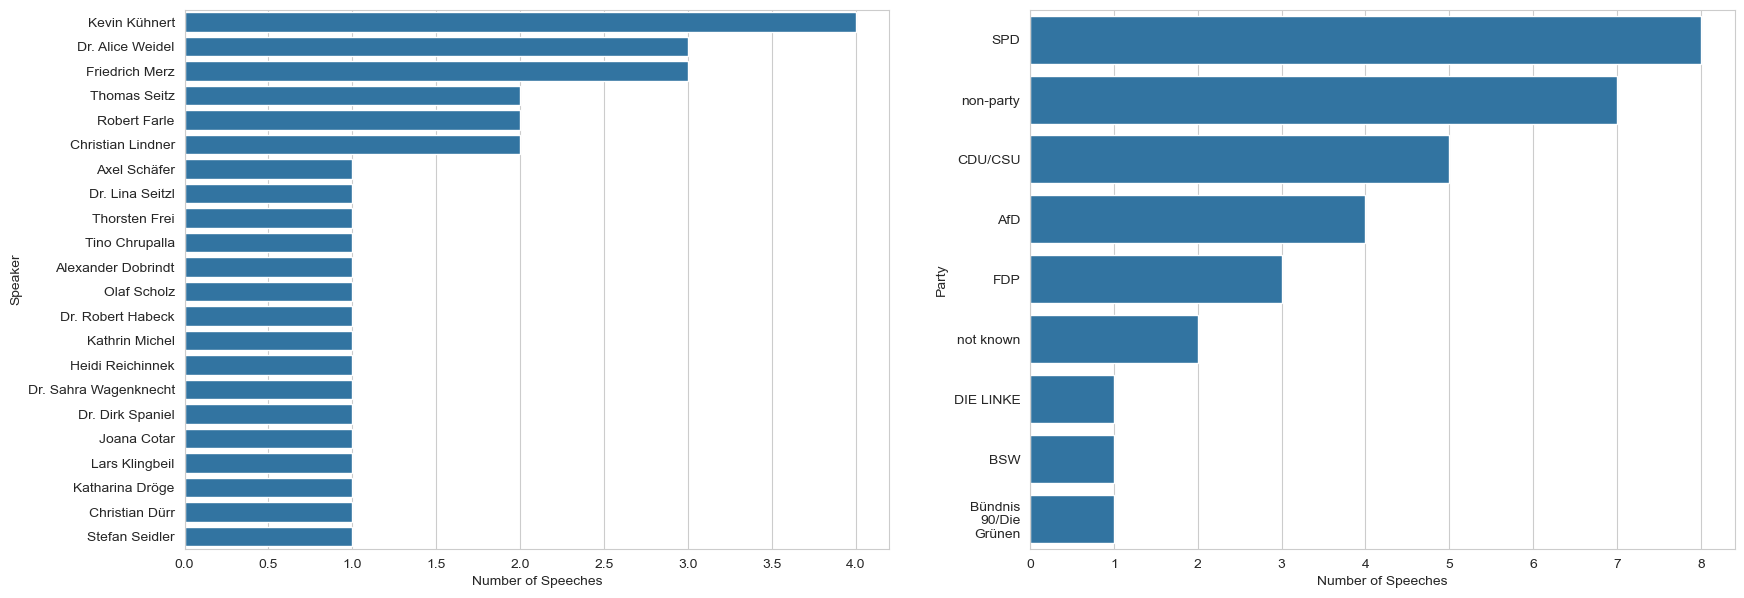

In [ ]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(20,7))

gs = fig.add_gridspec(nrows=1, ncols=2, hspace = 0.2)

grid = fig.add_subplot(gs[0, 0])
grid = sns.countplot(sel,
                     y="_source.name",
                     order = sel['_source.name'].value_counts().index)
grid.set(ylabel='Speaker', xlabel = 'Number of Speeches')


grid2 = fig.add_subplot(gs[0, 1])
grid2 = sns.countplot(sel,
                     y="_source.party",
                     order = sel['_source.party'].value_counts().index)
wrap_y_labels(grid2, 12, 0)
grid2.set(ylabel='Party', xlabel = 'Number of Speeches')

plt.show()

# Show number of interjections per speaker and party

In [ ]:
# Step 1: Explode the ‘_source.text_raw’ column so that each dictionary becomes a separate row
df_exploded = sel[['_source.speech_id', '_source.name', '_source.party', '_source.text_raw']].explode('_source.text_raw')
# Step 2: Converts the dictionaries in the ‘to_check’ column into separate columns
dict_df = pd.json_normalize(df_exploded['_source.text_raw'])
# Step 3: Add the normalised columns to the original DataFrame (without ‘_source.text_raw’)
result = df_exploded.drop(columns=['_source.text_raw']).reset_index(drop=True).join(dict_df)

In [ ]:
# Select only interjections
sel_itj = result[result['type'] == 'interjection']

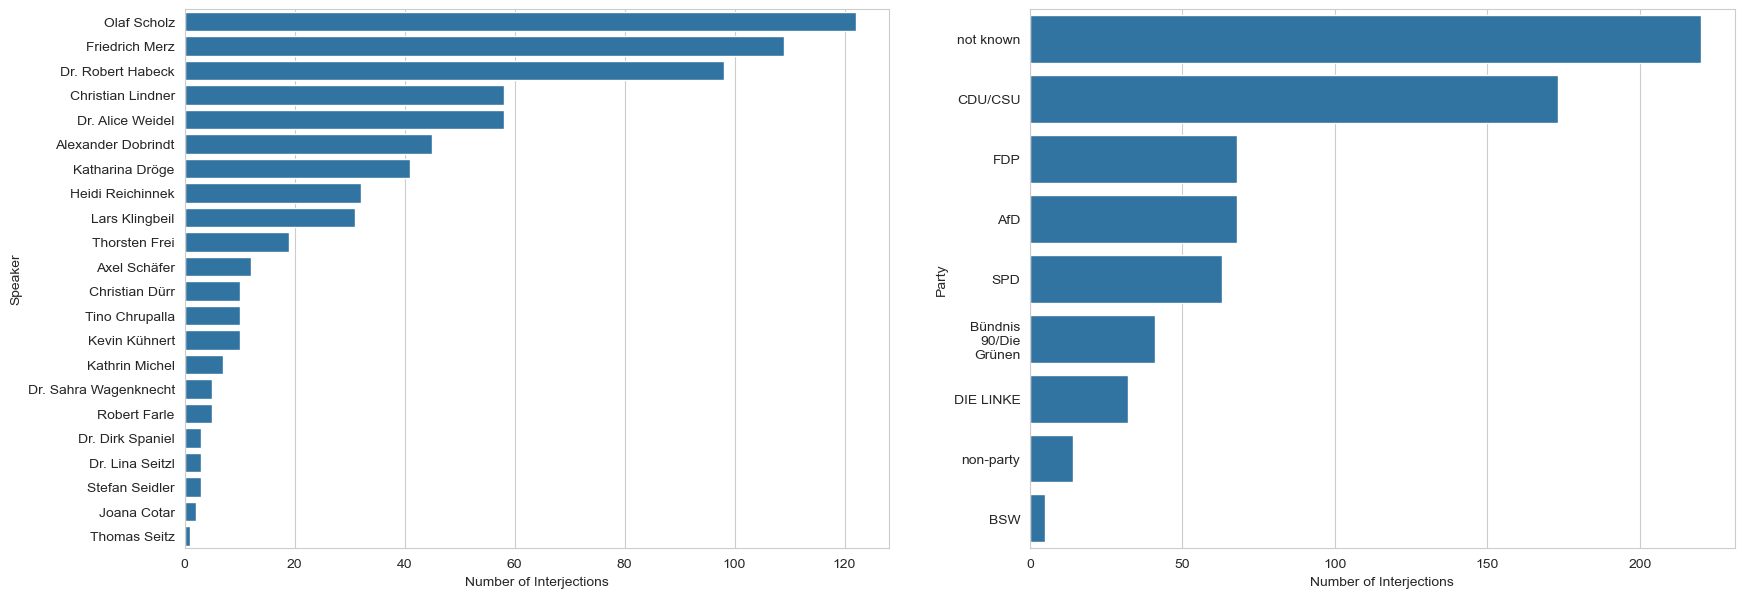

In [ ]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=(20,7))

gs = fig.add_gridspec(nrows=1, ncols=2, hspace = 0.2)

grid = fig.add_subplot(gs[0, 0])
grid = sns.countplot(sel_itj,
                     y="_source.name",
                     order = sel_itj['_source.name'].value_counts().index)
grid.set(ylabel='Speaker', xlabel = 'Number of Interjections')


grid2 = fig.add_subplot(gs[0, 1])
grid2 = sns.countplot(sel_itj,
                     y="_source.party",
                     order = sel_itj['_source.party'].value_counts().index)
wrap_y_labels(grid2, 12, 0)
grid2.set(ylabel='Party', xlabel = 'Number of Interjections')

plt.show()

## Create wordcloud

In [ ]:
# Import libraries
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
import numpy as np

In [ ]:
# Download stop word for German
stops = set(stopwords.words('german'))
add_stops = {'damen', 'herren', 'herr', 'frau', 'kollege', 'kollegen'}
stops.update(add_stops)

### CDU/CSU

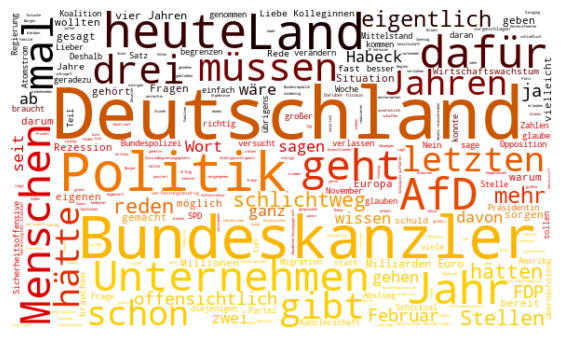

In [ ]:
# Select only speeches by CDU/CSU and not by session's president
sel_wcl = result[(result['type'] != 'interjection') & (result['_source.party'] == 'CDU/CSU')]
text = " ".join(s.strip() for s in sel_wcl.text.to_list())
# Generate a word cloud image
mask = np.array(Image.open("german_flag.PNG"))
wordcloud_por = WordCloud(stopwords=stops, background_color="white", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_por.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")


plt.show()


### AfD

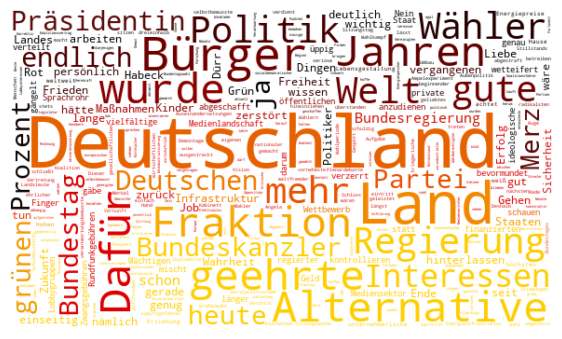

In [ ]:
# Select only speeches by AfD and not by session's president
sel_wcl = result[(result['type'] != 'interjection') & (result['_source.party'] == 'AfD')]
text = " ".join(s.strip() for s in sel_wcl.text.to_list())
# Generate a word cloud image
mask = np.array(Image.open("german_flag.PNG"))
wordcloud_por = WordCloud(stopwords=stops, background_color="white", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_por.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")


plt.show()

### Bündnis 90/Die Grünen

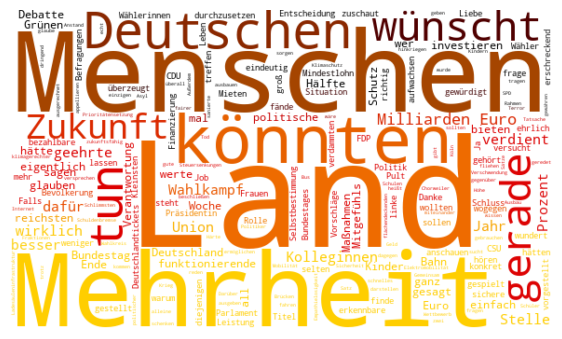

In [ ]:
# Select only speeches by Bündnis 90/Die Grünen and not by session's president
sel_wcl = result[(result['type'] != 'interjection') & (result['_source.party'] == 'Bündnis 90/Die Grünen')]
text = " ".join(s.strip() for s in sel_wcl.text.to_list())
# Generate a word cloud image
mask = np.array(Image.open("german_flag.PNG"))
wordcloud_por = WordCloud(stopwords=stops, background_color="white", max_words=1000, mask=mask).generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud_por.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")


plt.show()